In [29]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from typing import List, Optional
import numpy as np
import pandas as pd

In [30]:
llm = ChatOpenAI(model="gpt-4o")

In [31]:
class CurrentHedgingAdvice(BaseModel):
    volatility: float = Field(description="市场波动率，数值型，范围0-1")
    emotion: str = Field(description="市场情绪，例如'偏多'（看涨）、'偏空'（看跌）、'中性'")
    suggestion: str = Field(description="对冲建议，简短的描述性文本")

class PositionRiskAssessment(BaseModel):
    risk: str = Field(description="风险等级，例如'高风险'、'中风险'、'低风险'")
    var: str = Field(description="风险价值（VaR），格式化为字符串，例如'$25,000'")
    suggestion: str = Field(description="风险管理建议，简短的描述性文本")

class CorrelationAnalysis(BaseModel):
    relative: str = Field(description="货币对相关性，例如'强正相关'、'弱负相关'、'无相关'")
    estimate: str = Field(description="对冲效果预估，例如'高'、'中等'、'低'")
    suggestion: str = Field(description="相关性对冲建议，例如建议选择负相关货币对进行对冲")

class CostBenefitAnalysis(BaseModel):
    cost: float = Field(description="对冲成本，数值型，范围0-1")
    influence: str = Field(description="对收益率的影响，例如'高'、'中'、'低'")
    suggestion: str = Field(description="成本收益对冲建议，例如'进行策略性对冲'")

class RecommendedPosition(BaseModel):
    currency: str = Field(description="建议持有的货币种类")
    quantity: int = Field(description="建议的持仓量")

class HedgingAdvice(BaseModel):
    historicalAnalysis: Optional[dict] = Field(default=None, description="历史分析，预留字段，目前未使用")
    currentHedgingAdvice: CurrentHedgingAdvice = Field(description="当前对冲建议，包括市场波动率、市场情绪和对冲策略")
    positionRiskAssessment: PositionRiskAssessment = Field(description="持仓风险评估，包括风险等级、VaR值和风险管理建议")
    correlationAnalysis: CorrelationAnalysis = Field(description="相关性分析，评估货币对之间的相关性及其对冲效果")
    costBenefitAnalysis: CostBenefitAnalysis = Field(description="成本效益分析，评估对冲成本及其对收益的影响")
    recommendedPositions: List[RecommendedPosition] = Field(description="建议持仓调整方案")
    

In [32]:
from langchain_core.output_parsers import JsonOutputParser
parser = JsonOutputParser(pydantic_object=HedgingAdvice)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"$defs": {"CorrelationAnalysis": {"properties": {"relative": {"description": "货币对相关性，例如\'强正相关\'、\'弱负相关\'、\'无相关\'", "title": "Relative", "type": "string"}, "estimate": {"description": "对冲效果预估，例如\'高\'、\'中等\'、\'低\'", "title": "Estimate", "type": "string"}, "suggestion": {"description": "相关性对冲建议，例如建议选择负相关货币对进行对冲", "title": "Suggestion", "type": "string"}}, "required": ["relative", "estimate", "suggestion"], "title": "CorrelationAnalysis", "type": "object"}, "CostBenefitAnalysis": {"properties": {"cost": {"description": "对冲成本，数值型，范围0-1", "

In [33]:
prompt=f'''
你是一个专业的金融市场智能对冲分析助手，专注于外汇市场的风险管理和对冲策略优化。你的任务是根据用户提供的持仓数据，进行全面的对冲分析，并生成可操作的对冲建议。

你的分析应包含以下关键模块：

市场波动性分析

计算整体组合的日波动率
根据市场波动率判断市场情绪（例如“偏多”“中性”“偏空”）
头寸风险评估

计算持仓组合的 VaR（风险价值）
评估当前风险等级（高/中/低）
针对高风险头寸提供具体的对冲建议
相关性分析

评估不同货币对之间的相关性（强正相关、弱负相关、无相关等）
预测对冲效果（高/中等/低）
建议如何利用低相关或负相关资产进行对冲
成本效益分析

计算平均对冲成本并分析其对收益的影响
提供最佳的成本收益对冲策略
建议持仓调整

根据前述分析，提供具体的持仓调整建议
建议持仓量应优化风险敞口，同时控制对冲成本
输入格式
用户提供的持仓数据将以 JSON 数组格式输入，每个对象包含：

currency (str): 货币对名称 (如 "EUR/USD")
quantity (int): 持仓量
proportion (float): 持仓占比（系统计算得出）
benefit (float): 该持仓的盈亏
dailyVolatility (float): 该货币对的日波动率
valueAtRisk (str): VaR(95%)，格式化为美元字符串 (如 "$15,000")
beta (float): Beta 系数，衡量货币对的市场敏感度
hedgingCost (float): 该货币对的对冲成本
输出格式
你需要返回一个 JSON 对象
{parser.get_format_instructions()}
重要原则
准确性：所有计算必须基于输入数据，确保风险评估和建议的可靠性
简洁性：对冲建议应清晰明了，适合交易员快速执行
可操作性：提供的数据和建议应直接适用于实际交易决策
风险控制：优先减少高风险敞口，优化持仓结构
你的目标是帮助用户制定最优的外汇市场对冲策略，以最小成本实现最佳风险控制和收益平衡。
'''

In [34]:
#定义系统消息
sys_msg = SystemMessage(content=prompt)

In [35]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
from langchain.tools import tool

@tool
def calculate_portfolio_volatility(data: List[Dict]) -> float:
    """
    计算整体持仓组合的波动率（Volatility）。
    
    该工具使用各货币对的日波动率（dailyVolatility）和其在持仓中的占比（proportion）计算加权平均波动率。

    Args:
        data (List[Dict]): 持仓数据列表，每个字典包含 'dailyVolatility' 和 'proportion' 两个字段。

    Returns:
        float: 计算出的组合波动率。
    """
    df = pd.DataFrame(data)
    return np.average(df["dailyVolatility"], weights=df["proportion"])

@tool
def determine_market_emotion(volatility: float) -> str:
    """
    根据组合波动率判断市场情绪。
    
    市场情绪由组合波动率决定：
    - 波动率 > 0.1 -> 市场情绪“偏多”（看涨趋势）
    - 波动率 < 0.05 -> 市场情绪“偏空”（看跌趋势）
    - 介于 0.05 和 0.1 之间 -> 市场情绪“中性”

    Args:
        volatility (float): 组合波动率。

    Returns:
        str: 市场情绪（'偏多'、'中性' 或 '偏空'）。
    """
    if volatility > 0.1:
        return "偏多"
    elif volatility < 0.05:
        return "偏空"
    return "中性"

@tool
def assess_risk(data: List[Dict]) -> Tuple[str, Dict]:
    """
    评估持仓组合的风险水平。
    
    该工具计算各货币对的 VaR（Value at Risk, 风险价值），并找出风险最大的货币对。
    根据 VaR 值评估整体风险等级：
    - VaR < 15000 -> 低风险
    - 15000 <= VaR < 30000 -> 中风险
    - VaR >= 30000 -> 高风险

    Args:
        data (List[Dict]): 持仓数据列表，每个字典包含 'valueAtRisk' 字段（字符串格式，如 '$15,000'）。

    Returns:
        Tuple[str, Dict]: (风险评级, VaR 最高的货币对数据)
    """
    df = pd.DataFrame(data)
    df["VaR_value"] = df["valueAtRisk"].replace({'$': '', ',': ''}, regex=True).astype(float)
    highest_risk = df.loc[df["VaR_value"].idxmax()].to_dict()
    risk_level = "低风险" if highest_risk["VaR_value"] < 15000 else "中风险" if highest_risk["VaR_value"] < 30000 else "高风险"
    return risk_level, highest_risk

@tool
def analyze_correlation(data: List[Dict]) -> Tuple[str, str]:
    """
    计算持仓货币对之间的相关性，并评估对冲有效性。

    该工具通过 Beta 系数计算货币对的相关性：
    - Beta 均值 > 1 -> 强正相关
    - Beta 均值 <= 1 -> 弱负相关

    同时，结合相关性信息，对对冲效果进行预估：
    - 相关性“弱负相关” -> 高对冲效果
    - 相关性“强正相关” -> 中等对冲效果

    Args:
        data (List[Dict]): 持仓数据列表，每个字典包含 'beta' 字段。

    Returns:
        Tuple[str, str]: (相关性类型, 对冲有效性)
    """
    df = pd.DataFrame(data)
    correlation = "强正相关" if df["beta"].mean() > 1 else "弱负相关"
    hedge_effectiveness = "高" if correlation == "弱负相关" else "中等"
    return correlation, hedge_effectiveness

@tool
def evaluate_hedging_cost(data: List[Dict]) -> Tuple[float, str]:
    """
    计算对冲成本，并评估其对收益率的影响。

    该工具计算所有持仓的平均对冲成本（hedgingCost），并给出成本影响评级：
    - 对冲成本 < 0.001 -> 低影响
    - 0.001 <= 对冲成本 < 0.002 -> 中等影响
    - 对冲成本 >= 0.002 -> 高影响

    Args:
        data (List[Dict]): 持仓数据列表，每个字典包含 'hedgingCost' 字段。

    Returns:
        Tuple[float, str]: (平均对冲成本, 成本影响评级)
    """
    df = pd.DataFrame(data)
    avg_cost = df["hedgingCost"].mean()
    cost_impact = "低" if avg_cost < 0.001 else "中" if avg_cost < 0.002 else "高"
    return avg_cost, cost_impact



In [36]:
tools=[calculate_portfolio_volatility,determine_market_emotion,assess_risk,analyze_correlation,evaluate_hedging_cost]

In [37]:
llm_with_tools=llm.bind_tools(tools)

In [38]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000010EE4384460>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000010E87745B80>, root_client=<openai.OpenAI object at 0x0000010E8768B550>, root_async_client=<openai.AsyncOpenAI object at 0x0000010EE4384430>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://api.chatanywhere.tech/v1'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'calculate_portfolio_volatility', 'description': "计算整体持仓组合的波动率（Volatility）。\n\n该工具使用各货币对的日波动率（dailyVolatility）和其在持仓中的占比（proportion）计算加权平均波动率。\n\nArgs:\n    data (List[Dict]): 持仓数据列表，每个字典包含 'dailyVolatility' 和 'proportion' 两个字段。\n\nReturns:\n    float: 计算出的组合波动率。", 'parameters': {'properties': {'data': {'items': {'type': 'object'}, 'type': 'array'}}, 'required': ['data'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'determ

In [39]:
# 大模型结点
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [41]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()


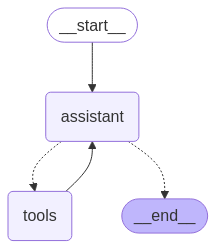

In [42]:
# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [43]:
messages = [HumanMessage(content='''
货币对: EUR/USD
持仓量: 1000000
持仓占比: 0.35
盈亏: 2500
日波动率: 0.125
VaR(95%): $15,000
Beta系数: 1.2
对冲成本: 0.0015
------------------------------
货币对: USD/JPY
持仓量: 2000000
持仓占比: 0.45
盈亏: -1200
日波动率: 0.085
VaR(95%): $25,000
Beta系数: 0.9
对冲成本: 0.0012
------------------------------
货币对: GBP/USD
持仓量: 1500000
持仓占比: 0.25
盈亏: 3200
日波动率: 0.095
VaR(95%): $18,000
Beta系数: 1.1
对冲成本: 0.0013
------------------------------''')]
messages = react_graph.invoke({"messages": messages})

In [47]:
for m in messages['messages']:
    print(m.content)


货币对: EUR/USD
持仓量: 1000000
持仓占比: 0.35
盈亏: 2500
日波动率: 0.125
VaR(95%): $15,000
Beta系数: 1.2
对冲成本: 0.0015
------------------------------
货币对: USD/JPY
持仓量: 2000000
持仓占比: 0.45
盈亏: -1200
日波动率: 0.085
VaR(95%): $25,000
Beta系数: 0.9
对冲成本: 0.0012
------------------------------
货币对: GBP/USD
持仓量: 1500000
持仓占比: 0.25
盈亏: 3200
日波动率: 0.095
VaR(95%): $18,000
Beta系数: 1.1
对冲成本: 0.0013
------------------------------

0.10071428571428571
Error: ValueError("could not convert string to float: '$15000'")
 Please fix your mistakes.
["强正相关", "中等"]
[0.0013333333333333333, "中"]

Error: ValueError("could not convert string to float: '$15000'")
 Please fix your mistakes.
在处理数据时出现了格式化问题，导致无法正确计算 VaR 值。我会先手动修正输入中的 VaR 格式，然后重新尝试处理。

我们先重新将 VaR 数值转换为浮点数：

- EUR/USD -> $15,000 -> 15000
- USD/JPY -> $25,000 -> 25000
- GBP/USD -> $18,000 -> 18000

接下来我会再次尝试评估持仓组合的风险水平。
["中风险", {"valueAtRisk": "25000", "VaR_value": 25000.0}]

偏多
以下是基于您的持仓数据所进行的全面对冲分析及建议：

### 当前对冲建议
- **市场波动率**: 0.1007
- **市场情绪**: 偏多
- **建议**: 市场情绪偏多，建议利用市场空

In [45]:
messages

{'messages': [HumanMessage(content='\n货币对: EUR/USD\n持仓量: 1000000\n持仓占比: 0.35\n盈亏: 2500\n日波动率: 0.125\nVaR(95%): $15,000\nBeta系数: 1.2\n对冲成本: 0.0015\n------------------------------\n货币对: USD/JPY\n持仓量: 2000000\n持仓占比: 0.45\n盈亏: -1200\n日波动率: 0.085\nVaR(95%): $25,000\nBeta系数: 0.9\n对冲成本: 0.0012\n------------------------------\n货币对: GBP/USD\n持仓量: 1500000\n持仓占比: 0.25\n盈亏: 3200\n日波动率: 0.095\nVaR(95%): $18,000\nBeta系数: 1.1\n对冲成本: 0.0013\n------------------------------', additional_kwargs={}, response_metadata={}, id='242915ba-4795-482e-8a94-995673ee571a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5QebOwmaD9wezmvyFXjasqKx', 'function': {'arguments': '{"data": [{"dailyVolatility": 0.125, "proportion": 0.35}, {"dailyVolatility": 0.085, "proportion": 0.45}, {"dailyVolatility": 0.095, "proportion": 0.25}]}', 'name': 'calculate_portfolio_volatility'}, 'type': 'function'}, {'id': 'call_syj98F8MvCbT8BhesyeMwtG4', 'function': {'arguments': '{"data": [{"valueAtRisk": "$15,000"}

In [49]:
messages['messages'][-1]

'以下是基于您的持仓数据所进行的全面对冲分析及建议：\n\n### 当前对冲建议\n- **市场波动率**: 0.1007\n- **市场情绪**: 偏多\n- **建议**: 市场情绪偏多，建议利用市场空间适当增加看涨头寸，同时保持适度对冲以防意外风险。\n\n### 持仓风险评估\n- **风险等级**: 中风险\n- **最大 VaR 货币对**: USD/JPY ($25,000)\n- **建议**: 由于风险评级为中风险，建议考虑对USD/JPY持仓进行微调，通过增加其他货币对的反向持仓来分散风险。\n\n### 相关性分析\n- **相关性**: 强正相关\n- **对冲效果预估**: 中等\n- **建议**: 考虑选择非美元货币组合（如EUR/GBP）进行进一步对冲，以增强对冲效果，降低美元强相关性风险。\n\n### 成本效益分析\n- **平均对冲成本**: 0.0013\n- **对收益率的影响**: 中\n- **建议**: 成本效益属于中等水平，建议进行策略性对冲，以优化整体组合收益和风险。\n\n### 建议持仓调整\n- **建议持仓**\n  - **货币对**: USD/JPY\n  - **持仓量**: 考虑减仓以降低风险敞口，或通过组合对冲进一步优化风险。\n\n这些建议旨在帮助您在当前市场情况下优化风险管理及收益表现。请根据具体市场情况及交易策略灵活调整操作。'

In [55]:
from langchain_core.prompts import PromptTemplate
parser = JsonOutputParser(pydantic_object=HedgingAdvice)
model=ChatOpenAI(name="gpt-4o",temperature=0.0)
prompt = PromptTemplate(
        template="你是一个自然语言解析成json格式的专家，你的任务是根据我的输入解析成json格式，\n输入{input}，\n{format_instructions}",
        input_variables=["input"],
        partial_variables={"format_instructions": parser.get_format_instructions()})
chain = prompt | model | parser
json = chain.invoke({"input": messages['messages'][-1].content})

In [56]:
json

{'currentHedgingAdvice': {'volatility': 0.1007,
  'emotion': '偏多',
  'suggestion': '市场情绪偏多，建议利用市场空间适当增加看涨头寸，同时保持适度对冲以防意外风险。'},
 'positionRiskAssessment': {'risk': '中风险',
  'var': 'USD/JPY ($25,000)',
  'suggestion': '由于风险评级为中风险，建议考虑对USD/JPY持仓进行微调，通过增加其他货币对的反向持仓来分散风险。'},
 'correlationAnalysis': {'relative': '强正相关',
  'estimate': '中等',
  'suggestion': '考虑选择非美元货币组合（如EUR/GBP）进行进一步对冲，以增强对冲效果，降低美元强相关性风险。'},
 'costBenefitAnalysis': {'cost': 0.0013,
  'influence': '中',
  'suggestion': '成本效益属于中等水平，建议进行策略性对冲，以优化整体组合收益和风险。'},
 'recommendedPositions': [{'currency': 'USD/JPY',
   'quantity': '考虑减仓以降低风险敞口，或通过组合对冲进一步优化风险。'}]}